Dataset used: https://www.kaggle.com/moltean/fruits

In [1]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
# -*- coding: utf-8 -*-
"""Untitled1.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1O_5jpeuCApyOLSeDH4uPCG-y_zw_iX4t
"""
from keras import regularizers
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
from keras.utils.vis_utils import plot_model
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score

In [0]:
# paths to load datasets
dir_path = 'drive/My Drive/Fruits/'
data_path = dir_path + 'fruits-360_dataset/fruits-360/'
train_path = data_path + 'Training/'
test_path = data_path + 'Test/'

embedding_path = dir_path + 'embeddings/'

## get data

In [0]:
################################################
############ data generation
################################################


def get_dir_images(data_path):
  """return the differents categories, the images in these categories, and the number of images per category"""
  listDir = sorted(os.listdir(data_path))
  lis = [7,13,14,16,26,33,34,39,54,59]
  size = []
  listFiles = []
  target = []
  target_name = []
  i = 0
  for d in np.array(listDir)[lis] :
    files = sorted(os.listdir(data_path+'/'+d))
    size.append(len(files))
    files = [data_path+'/'+d+'/'+f for f in files]
    target_name += [d] * len(files)
    target += [i] * len(files)
    i += 1
    listFiles += files
  return listFiles, target_name, np.array(target), size
  

def get_images(listFiles, input_shape=(100,100,3)):
  images = []
  for f in listFiles:
    img = image.load_img(f, target_size=input_shape)
    img = np.array(img)/255.
    images.append(img)
  return np.array(images)


def group_data(imgs, target):
  grouped_data = {}
  for i in range(10):
    grouped_data[i] = imgs[np.argwhere(target==i)[:,0]]
  return grouped_data

def get_batch(grouped_data, num_list):
  target = []
  batch = []
  data_ = grouped_data

  num_example = min([data_[i].shape[0] for i in num_list])
  print('getting {} examples'.format(num_example))
  for i in range(round(num_example*len(num_list))):
    i1,i2 = np.random.choice(num_list,2, replace=False)
    i_index = np.random.choice(num_example,4, replace=False)
    batch += [[data_[i1][i_index[0]], data_[i1][i_index[1]]]]
    batch += [[data_[i1][i_index[2]], data_[i2][i_index[3]]]]
    target.append(1)
    target.append(0)
  return np.array(batch), np.array(target)

def get_test_batch(grouped_data, test_size, test_target, categ_target, k=10):#k-way one shot learning
  batch = [np.zeros((test_size*k, 32, 32, 3)) for i in range(2)]
  # batch = []
  target = [] # index of correct category
  num_list = test_target
  categ_list = categ_target
  data_ = grouped_data
  for i in range(test_size):
    i1 = np.random.choice(num_list)
    i1_index = np.random.choice(data_[i1].shape[0])
    batch[0][i*k:i*k+k,:] = np.repeat(data_[i1][i1_index][np.newaxis,:], k, axis=0)
    target.append(i1)
    for k_i in range(k):
      i2_index = np.random.choice(data_[categ_list[k_i]].shape[0])
      batch[1][i*k+k_i,:] = data_[categ_list[k_i]][i2_index]
      while categ_list[k_i]==i1 and i2_index == i1_index:
        i2_index = np.random.choice(data_[categ_list[k_i]].shape[0])
        batch[1][i*k+k_i,:] = data_[categ_list[k_i]][i2_index]
    
  return batch, target


## create siamese model

In [0]:
num_class = 10
feature_dim = 3


################################################
############ Model Building
################################################

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
  '''Contrastive loss from Hadsell-et-al.'06
  http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
  '''
  margin = 15
  square_pred = K.square(y_pred)
  margin_square = K.square(K.maximum(margin - y_pred, 0))
  return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def get_siamese_model(input_shape, distance = 'l1'):
    
  left_input = Input(input_shape, name='input1')
  right_input = Input(input_shape, name='input2')
  
  model = Sequential()
  model.add(Conv2D(128, (3, 3), padding='same',input_shape=input_shape, kernel_regularizer=regularizers.l2(0.0001)))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Activation('relu'))
  model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Activation('relu'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Activation('relu'))

  # model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
  # model.add(Activation('relu'))

  model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Flatten())

  model.add(Dense(512, activation='relu', name='dense1'))
  model.add(Dropout(0.5, name='dropout1'))
  model.add(Dense(256, activation='relu', name='dense2'))
  model.add(Dropout(0.3, name='dropout2'))
  encoded_l = model(left_input)
  encoded_r = model(right_input)

  if distance == 'l1':
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)

    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

  else:
    distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([encoded_l, encoded_r])

    siamese_net = Model([left_input,right_input], distance)
  return siamese_net


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred<0.5, y_true.dtype)))

def get_model_performance(model, batch, targets, val_batch, val_targets):
  y_pred = model.predict([batch[:, 0], batch[:, 1]])
  tr_acc = np.mean(((y_pred.ravel() < 0.5) == targets))
  y_pred = model.predict([val_batch[:, 0], val_batch[:, 1]])
  te_acc = np.mean(((y_pred.ravel() < 0.5) == val_targets))

  print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
  print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

def get_one_shot_performance(model, distance):
  test_size = 4096
  batch, target = get_test_batch(grouped_data, test_size, test_num_list, all_num_list, k=10)
  y_pre = model.predict(batch)
  if distance == 'l1':
    pre = np.argmax(y_pre.reshape(-1,len(all_num_list)),axis=1)
  else:
    pre = np.argmin(y_pre.reshape(-1,len(all_num_list)),axis=1)
  return accuracy_score(target, pre), confusion_matrix(target, pre)

def get_one_shot_performance_all_dataset(model, distance):
  test_size = 4096
  batch, target = get_test_batch(grouped_data, test_size, all_num_list, all_num_list, k=10)
  y_pre = model.predict(batch)
  if distance == 'l1':
    pre = np.argmax(y_pre.reshape(-1,len(all_num_list)),axis=1)
  else:
    pre = np.argmin(y_pre.reshape(-1,len(all_num_list)),axis=1)
  return accuracy_score(target, pre), confusion_matrix(target, pre)

################################################
############ Feature Model
################################################

def get_feature_model(model):
  feature_model = Model(inputs=model.input, outputs=model.layers[3].input)
  return feature_model

def get_features(feature_model, data):
  data_sz = data.shape[0]
  if data_sz%2 == 0:
    features = feature_model.predict([data[:data_sz//2], data[data_sz//2:]])
    return np.concatenate((features[0], features[1]), axis = 0)
  else:
    features = feature_model.predict([data[:data_sz//2], data[data_sz//2:-1]])
    features = np.concatenate((features[0], features[1]), axis = 0)
    last_feature = feature_model.predict([data[-1][np.newaxis,:], data[-1][np.newaxis,:]])[0]
    return np.concatenate((features, last_feature), axis = 0)


def get_features_(feature_model, data):
  features = feature_model.predict([data, data])
  return features[0]

def get_labeled_features(feature_model, data, list_labels):
  features = np.array([]).reshape((0,feature_dim))
  targets = []
  for i in list_labels:
    data_ = data.grouped_data[i]
    features_ = get_features_(feature_model, data_)
    print(features_)
    features = np.concatenate((features, features_), axis = 0)
    targets_ = [i] * features_.shape[0]
    targets += targets_
  return features, targets

################################################
############ Plot
################################################

def plot_history(history, with_val = False):
  history_dict = history.history
  loss_values = history_dict['loss']
  if with_val:
    val_loss_values = history_dict['val_loss']
  epochs = range(1, len(loss_values) + 1)
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, label='Training loss')
  if with_val:
    plt.plot(epochs, val_loss_values, label='Validation loss')
  plt.title('Training loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  acc = history_dict['accuracy']
  if with_val:
    val_acc = history_dict['val_accuracy']
  plt.subplot(1,2,2)
  plt.plot(epochs, acc, label='Training acc')
  if with_val:
    plt.plot(epochs, val_acc, label='Validation acc')
  plt.title('Training acc')
  plt.xlabel('Epochs')
  plt.ylabel('acc')
  plt.legend()
  
  plt.show()

def plot_feature(features, labels):
  if feature_dim == 2:
    fig, ax = plt.subplots()
    scatter = ax.scatter(features[: ,0], features[:,1], c=labels, s=3)
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Class")
    ax.add_artist(legend1)
  else:
    fig = plt.figure()
    ax = Axes3D(fig)
    scatter = ax.scatter(features[:,0], features[:,1], features[:,2], c=labels, s=3)
    legend1 = ax.legend(*scatter.legend_elements(), title="Class")
    ax.add_artist(legend1)
  plt.show()

def plot_and_save_feature(features, labels, i):
  if feature_dim == 2:
    fig, ax = plt.subplots()
    scatter = ax.scatter(features[: ,0], features[:,1], c=labels, s=3)
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Class")
    ax.add_artist(legend1)
  else:
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(features[:,0], features[:,1], features[:,2], c=labels)
    legend1 = ax.legend(*scatter.legend_elements(), title="Class")
    ax.add_artist(legend1)
  plt.savefig('/content/drive/My Drive/'+str(i)+'.png')
  plt.show()


## load data

In [6]:
load_data = True

if load_data:
  images = np.load(data_path+'images2.npy')
  test_images = np.load(data_path+'test_images2.npy')
  targets = np.load(data_path+'targets2.npy')
  test_targets = np.load(data_path+'test_targets2.npy')
  print(images.shape)
else:
  listFiles, target_name, targets, size = get_dir_images(train_path)
  test_listFiles, test_target_name, test_targets, size = get_dir_images(train_path)

  images = get_images(listFiles, input_shape = input_shape)
  test_images = get_images(test_listFiles, input_shape = input_shape)

data_augmentation = True
if data_augmentation:
  
  datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
  datagen.fit(images)
  i=0
  for X_batch, y_batch in datagen.flow(images, targets, batch_size=124):
    images = np.concatenate((images, X_batch),axis=0)
    targets = np.concatenate((targets, y_batch),axis=0)
    i += 1
    if i == 10:
      break
  print(images.shape)

(5339, 32, 32, 3)


In [10]:
train_num_list = list(range(5))
val_num_list = list(range(5))
test_num_list = list(range(5,10))
all_num_list = list(range(10))
input_shape = (32, 32, 3)

grouped_data = group_data(images, targets)
test_grouped_data = group_data(test_images, test_targets)

batch, target = get_batch(grouped_data, train_num_list)
val_batch, val_target = get_batch(test_grouped_data, val_num_list)
test_batch, test_target = get_batch(test_grouped_data, test_num_list)

getting 427 examples
getting 143 examples
getting 164 examples


In [52]:
epochs = 20
batch_size = 128

distance = 'euclidean'
# distance = 'l1'
model= get_siamese_model(input_shape, distance)

opt = RMSprop()
# opt = Adam()
model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy])

history = model.fit([batch[:, 0], batch[:, 1]], target ,batch_size=batch_size,
          epochs=epochs, validation_data=([val_batch[:,0],val_batch[:,1]], val_target))

plot_history(history, with_val=True)

model.evaluate([test_batch[:,0],test_batch[:,1]],test_target)

Train on 4270 samples, validate on 1430 samples
Epoch 1/20
4270/4270 [==============================] - 30s 7ms/step - loss: 50.4079 - accuracy: 0.5000 - val_loss: 73.6255 - val_accuracy: 0.8154
Epoch 2/20
4270/4270 [==============================] - 27s 6ms/step - loss: 54.3520 - accuracy: 0.5000 - val_loss: 57.5764 - val_accuracy: 0.7699
Epoch 3/20
4270/4270 [==============================] - 27s 6ms/step - loss: 48.0471 - accuracy: 0.5000 - val_loss: 51.7851 - val_accuracy: 0.7818
Epoch 4/20
4270/4270 [==============================] - 27s 6ms/step - loss: 43.9114 - accuracy: 0.5000 - val_loss: 39.3874 - val_accuracy: 0.6951
Epoch 5/20
2944/4270 [===================>..........] - ETA: 7s - loss: 41.2834 - accuracy: 0.5102

KeyboardInterrupt: ignored

## Model evaluation

In [0]:
model_path = dir_path+'fruits_0.79.h5'
model = load_model(model_path, custom_objects={'contrastive_loss': contrastive_loss, "accuracy" : accuracy})

In [70]:
model.evaluate([batch[:,0],batch[:,1]],target)

4270/4270 [==============================] - 8s 2ms/step


[81.74640382503179, 0.8480093676256631]

In [77]:
model.evaluate([test_batch[:,0],test_batch[:,1]],test_target)

1640/1640 [==============================] - 3s 2ms/step


[77.80674438476562, 0.9170731707317074]

In [0]:
def plot_cm(cm, test_flag = True):
  target_name = ['Apple Red 1', 'Apricot','Avocado', 'Banana','Cherry 1', 'Clementine','Cocos', 'Grape Blue','Lemon', 'Mango']
  df_cm = pd.DataFrame(cm, columns=target_name, index = target_name)
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (12,10))
  sns.set(font_scale=1.3)#for label size
  sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 13})# font size

acc in test set: 0.772216796875


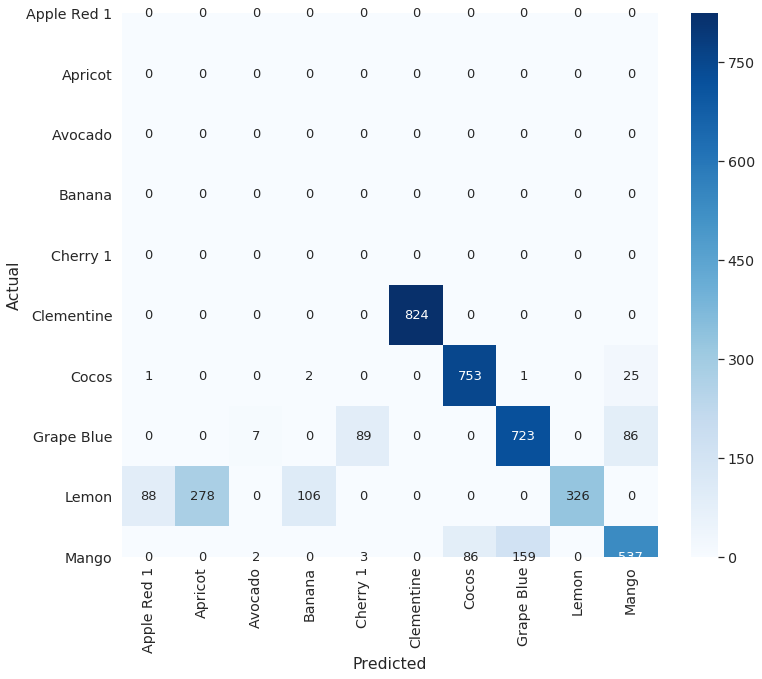

In [73]:
distance = 'euclidean'
acc, cm = get_one_shot_performance(model, distance)
print('acc in test set: {}'.format(acc))
plot_cm(cm,True)

acc in all dataset: 0.69384765625


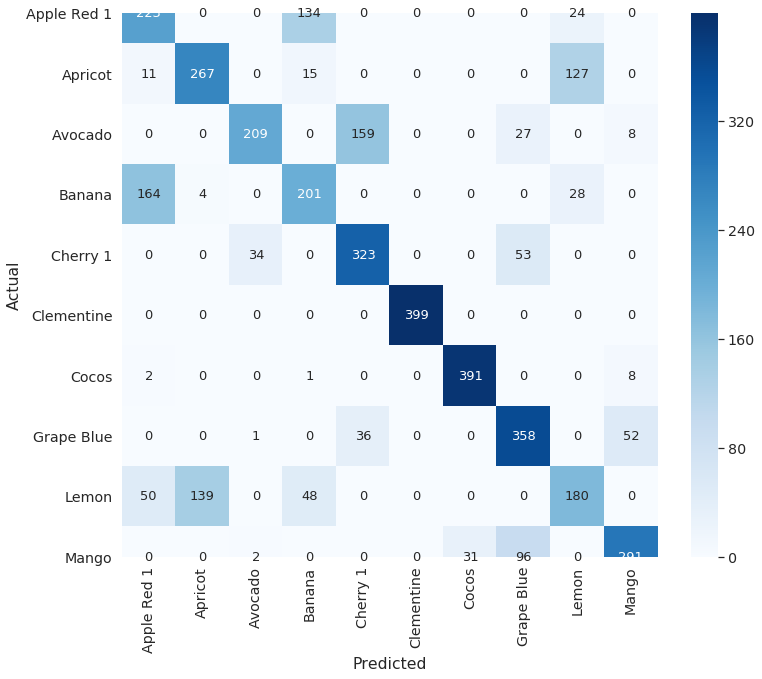

In [75]:
acc, cm_all = get_one_shot_performance_all_dataset(model, distance)
print('acc in all dataset: {}'.format(acc))
plot_cm(cm_all, False)

## Visualisation

In [0]:
feature_model = get_feature_model(model)
features = get_features_(feature_model, images)

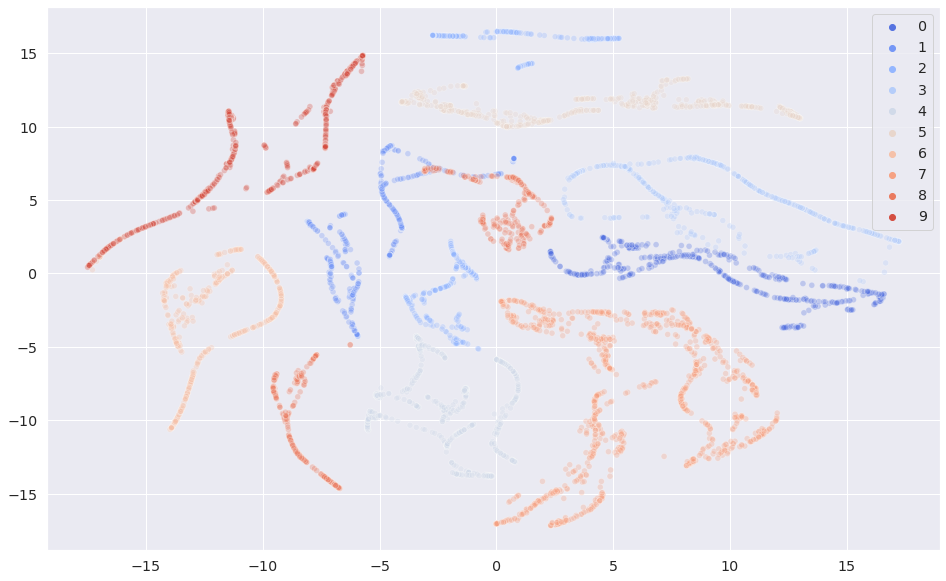

In [91]:
from sklearn.manifold import TSNE
import time

data_subset = features
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],palette=sns.color_palette('coolwarm', n_colors=10), hue=targets,legend="full", alpha=0.3)

## save data

In [0]:
np.save(data_path+'images2.npy', images)
np.save(data_path+'test_images2.npy', test_images)
np.save(data_path+'targets2.npy', targets)
np.save(data_path+'test_targets2.npy', test_targets)

In [0]:
np.save(data_path+'cm_all.npy', cm_all)

## save model

In [0]:
model.save(dir_path+'fruits_0.79.h5')